# Project Title
Recognising hate speech on twitter (vs offensive language)

### Data description
The dataset contains 24,783 tweets by the twitter users. -- To be fill --

***Data Dictionary***

-- To be fill --


## Part 1: Importing Dataset

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
#set first col as index
main_data = pd.read_csv("Data/labeled_data.csv", index_col=0)
main_data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Importing the Dataset

In [84]:
main_data.info()
#dataframe informationk


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [85]:
#add a column called length (number of characters)
main_data["length"] = main_data['tweet'].apply(len)

In [86]:
main_data.describe()
# Descriptive statistics

,count,hate_speech,offensive_language,neither,class,length
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277,85.523625
std,0.883060,0.631851,1.399459,1.113299,0.462089,41.646293
min,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000,52.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000,81.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000,119.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000,756.000000


<Figure size 640x480 with 0 Axes>

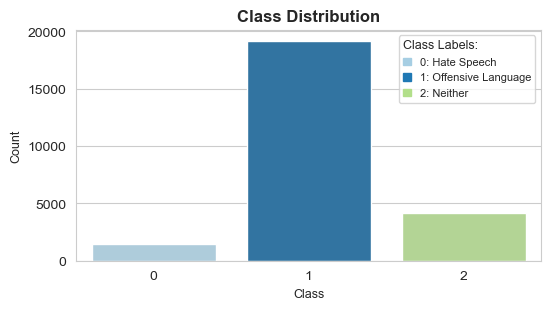

In [87]:
#Visualize class distribution to check for class imbalance
from matplotlib.patches import Rectangle

# Count the frequency of each class
class_counts = main_data['class'].value_counts()

#set seaborn aesthetics
palette = sns.color_palette("Paired", len(class_counts))
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

#plot
plt.figure(figsize=(6, 3))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)
legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=palette[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)
plt.title('Class Distribution', weight='bold')
plt.xlabel('Class', size=9)
plt.ylabel('Count', size=9)
plt.show()

**Key Takeaway**: massive class imbalance -> dataset is biased toward offensive tweets

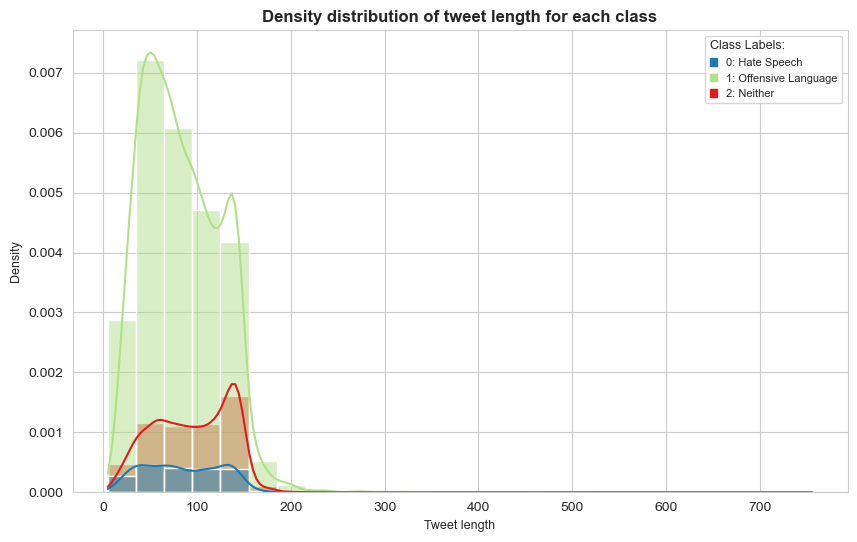

In [88]:
#Visualize tweet length distribution for each class
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Paired")
selected_colors = [palette[1], palette[2], palette[5]] 

ax = sns.histplot(data=main_data, x='length', hue='class', stat='density', bins=25, kde=True, palette=selected_colors)

legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=selected_colors[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)
plt.title('Density distribution of tweet length for each class', weight='bold')
plt.xlabel('Tweet length', size=9)
plt.ylabel('Density', size=9)

plt.show()

**Key Takeaway:** Offensive tweets tend to be the shortest.

Adding a new column to this dataset as labels which will contain the values as:

1. Hate Speech
2. Offensive Language
3. No Hate and Offensive

In [89]:
# main_data["labels"] = main_data["class"].map({0: "Hate Speech", 
#                                     1: "Offensive Language", 
#                                     2: "No Hate and Offensive"})
main_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,length
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,140
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137


In [90]:
main_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
 6   length              24783 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.5+ MB


In [91]:
# main_data[main_data["labels"]=="Hate Speech"].shape[0]

In [92]:
# main_data[main_data["labels"]=="Offensive Language"].shape[0]

In [93]:
# main_data[main_data["labels"]=="No Hate and Offensive"].shape[0]

In [94]:
main_data["tweet"].iloc[2]

'!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit'

Now we only select the tweet and labels columns for the rest of the task of training a hate speech detection model:

i.e. Selecting only the relevant columns which are tweets and labels

In [95]:
relevant_data = main_data[["tweet", "class"]]
relevant_data.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [96]:
#getting the sum of duplicates
relevant_data.duplicated().sum()

0

## Part 2: Data Preprocessing

In [97]:
import re
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
from nltk.corpus import stopwords            #to filter out useless data
import nltk
nltk.download('wordnet')
nltk.download('punkt')
stopword = set(stopwords.words('english'))
import string

[nltk_data] Downloading package wordnet to C:\Users\Bodine
[nltk_data]     Stubbé\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Bodine
[nltk_data]     Stubbé\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [98]:
import emoji

def convert_emoji_to_unicode_to_word(tweet): 
    
    emoji_list = re.findall(r'&#\d+;',tweet)
    
    for emoji_str in emoji_list:
        decimal_code_point = int(emoji_str.replace("&#", "").replace(";",""))
        tweet = tweet.replace(emoji_str, emoji.demojize(chr(decimal_code_point)).replace("_"," ")+" ")
    return tweet

In [99]:
def clean(text):
    #Convert the tweet to lowercase
    text = str(text).lower()
    
    if re.match("&#\d+;", text):
        text = convert_emoji_to_unicode_to_word(text)
        
    if re.match("^[^&][\S]+", text):
        text = re.sub(r'#', ' ', text)
    text = re.sub(r'&[a-z0-9]+;', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # text = re.sub(r"\@w+|\#",'',text)
    #remove username from the tweet starting with @
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # #remove "rt" from the tweet
    text = re.sub(r'rt ', '', text, flags=re.IGNORECASE)
    # Remove all special characters except for astrisk to preserve the meaning of the tweet
    text = re.sub(r'[^a-z0-9*\s]', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [100]:
# relevant_data.tweet = relevant_data['tweet'].apply(clean)
relevant_data = relevant_data.copy()
relevant_data.tweet = relevant_data["tweet"].apply(clean)

In [101]:
relevant_data.head()

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1


In [102]:
#getting the sum of duplicates
relevant_data.duplicated().sum()

869

In [103]:
duplicates = relevant_data[relevant_data.duplicated(keep='first')]
duplicates

,tweet,class
572,hoes aint loyal,1
892,porn android iphone ipad sex xxx desi paki,2
902,porn android iphone ipad sex xxx hairy hairy p...,1
1373,twitter rappers dm trash links,2
1479,way fuck ur bitch,1
...,...,...
25172,hoe,1
25237,give bitch inch rather,1
25261,yo hoe get slayed,1
25262,yo hoe get slayed,1


In [104]:
relevant_data["tweet"].iloc[1007]

'face tears joy face tears joy fucking god bruh birds southridge front house'

In [105]:
#imports for wordcloud visualization
from wordcloud import WordCloud
from PIL import Image
import requests

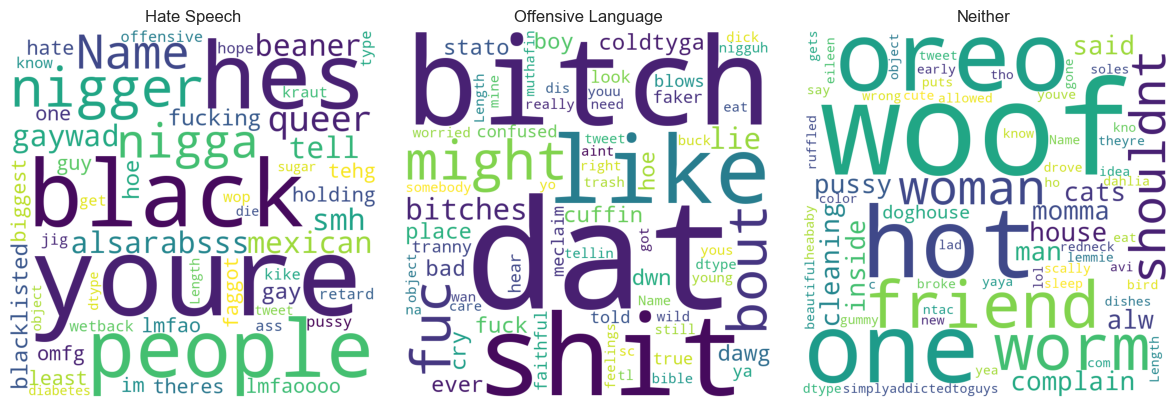

In [106]:
#wordclouds before removing duplicates

#pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png',stream=True).raw))
fig, axs = plt.subplots(1,3,figsize=(12,4))

for category, ax in zip([0, 1, 2], axs.flatten()):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10,
                random_state=42, 
                max_words=500).generate(str(relevant_data.loc[relevant_data["class"]==category, 'tweet']))
    ax.imshow(wordcloud)
    ax.axis('off')

axs[0].set_title("Hate Speech")
axs[1].set_title("Offensive Language")
axs[2].set_title("Neither")

plt.tight_layout() 
plt.show()


In [107]:
# removing duplicate data
new_data = relevant_data.drop_duplicates("tweet")

In [108]:
# to see updated number of columns as duplicates entries are removed
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23866 entries, 0 to 25296
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   23866 non-null  object
 1   class   23866 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 559.4+ KB


<Figure size 640x480 with 0 Axes>

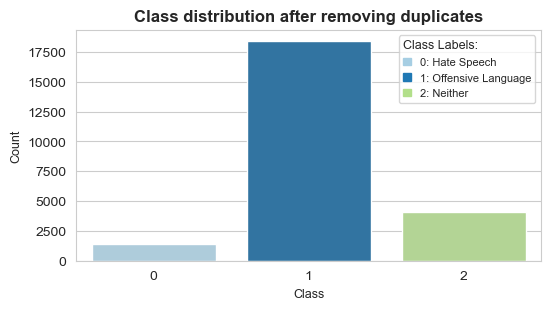

In [109]:
#class distribution after removing duplicates
class_counts = new_data['class'].value_counts()

palette = sns.color_palette("Paired", len(class_counts))
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

#plot
plt.figure(figsize=(6, 3))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)
legend_labels = ['0: Hate Speech', '1: Offensive Language', '2: Neither']
legend_handles = [Rectangle((0, 0), 1, 1, color=palette[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, fontsize=8, handlelength=0.7, title="Class Labels:", alignment='left', title_fontsize=9)
plt.title('Class distribution after removing duplicates', weight='bold')
plt.xlabel('Class', size=9)
plt.ylabel('Count', size=9)
plt.show()

In [110]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [111]:
#lemmatizing the processed data
new_data = new_data.copy()
new_data['tweet']=new_data['tweet'].apply(lambda x: lemmatizing(x))

In [112]:
new_data.head()

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1


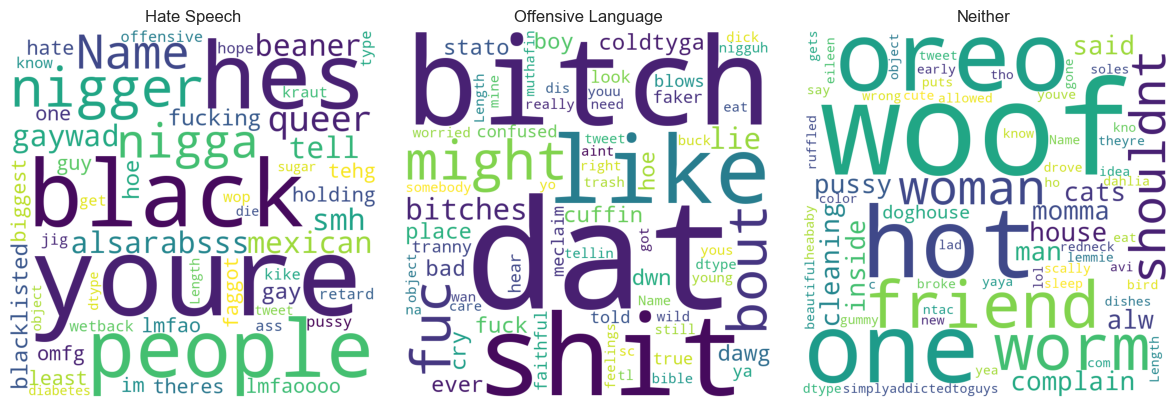

In [113]:
#wordclouds after removing duplicates and lemmatizing
fig, axs = plt.subplots(1,3,figsize=(12,4))

for category, ax in zip([0, 1, 2], axs.flatten()):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10,
                random_state=42, 
                max_words=200).generate(str(new_data.loc[new_data["class"]==category, 'tweet']))
    ax.imshow(wordcloud)
    ax.axis('off')

axs[0].set_title("Hate Speech")
axs[1].set_title("Offensive Language")
axs[2].set_title("Neither")

plt.tight_layout() 
plt.show()

## Part 3: Splitting and Oversampling of data

In [114]:
from sklearn.model_selection import train_test_split
#splitting the data into train, validation and test 0.6, 0.2, 0.2
X, X_test, y, y_test = train_test_split(new_data['tweet'], new_data['class'],  test_size=0.2, random_state=424)

In [115]:
#splitting the data into train and validation
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75)

In [116]:
X_train.head()

13037    man rather see morning selfies bitches dont ch...
23746                                    bitches make sick
5996                                       grow pair pussy
11869    someone pushes hard today may surprised ho cap...
6410     dykes arent even human tbh like empowered dres...
Name: tweet, dtype: object

Feature extraction: Count Vectorization & TFIDF vectorization

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#Count Vectorizing the X_train
count_vec = CountVectorizer()
count_vec.fit(X_train)

X_train_count = count_vec.transform(X_train)
X_train_tf = X_train_count.toarray()

#Count Vectorizing the X_cv
X_cv_count = count_vec.transform(X_cv)
X_cv_count = X_cv_count.toarray()

#Count Vectorizing the X_test
X_test_count = count_vec.transform(X_test)
X_test_count = X_test_count.toarray()


In [126]:
count_vec.vocabulary_

{'man': 8473,
 'rather': 11210,
 'see': 12112,
 'morning': 9048,
 'selfies': 12142,
 'bitches': 1307,
 'dont': 3905,
 'change': 2283,
 'look': 8235,
 'case': 2140,
 'mondays': 9003,
 'jaybey': 7249,
 'poster': 10698,
 'ijs': 6818,
 'make': 8444,
 'sick': 12499,
 'grow': 5879,
 'pair': 10062,
 'pussy': 11018,
 'someone': 12931,
 'pushes': 11008,
 'hard': 6090,
 'today': 14315,
 'may': 8607,
 'surprised': 13682,
 'ho': 6416,
 'capricorn': 2082,
 'dykes': 4162,
 'arent': 542,
 'even': 4487,
 'human': 6662,
 'tbh': 13896,
 'like': 8051,
 'empowered': 4352,
 'dress': 4019,
 'alien': 271,
 'shit': 12360,
 'please': 10538,
 'acknowledge': 68,
 'existence': 4553,
 'amazing': 347,
 'son': 12944,
 'bitch': 1299,
 'bet': 1189,
 'smell': 12785,
 'dried': 4027,
 'oysters': 10020,
 'try': 14598,
 'take': 13804,
 'othot': 9937,
 'drugs': 4073,
 'im': 6841,
 'get': 5531,
 'granny': 5799,
 'longjohns': 8232,
 'rednecksfor': 11321,
 'cold': 2676,
 'bones': 1521,
 'polar': 10589,
 'vortex': 15180,
 'sequ

In [128]:
#TFIDF Vectorizing the X_train

tfidf = TfidfVectorizer()

X_train_tf = tfidf.fit_transform(X_train)
X_train_tf = X_train_tf.toarray()


In [129]:
#TFIDF Vectorizing the X_test
X_test_tf = tfidf.transform(X_test)
X_test_tf = X_test_tf.toarray()

In [131]:
#Vectorizing the X_cv
X_cv_tf = tfidf.transform(X_cv)
X_cv_tf = X_cv_tf.toarray()

In [132]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("Before Oversampling:{}".format(Counter(y_train)))
# # define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='all')
# # fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train_tf, y_train)
print("After Oversampling:{}".format(Counter(y_train_over)))

Before Oversampling:Counter({1: 11089, 2: 2455, 0: 775})
After Oversampling:Counter({1: 11089, 2: 11089, 0: 11089})


In [ ]:
def oversample(X_train_vectorized):

In [ ]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_preds = nb.predict(X_test_count)
print(y_preds)

[1 1 1 ... 1 1 1]


In [ ]:
from sklearn.metrics import classification_report
print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds, target_names = ['Hate', 'Offensive', 'Neither']))

0.8627984918307499
              precision    recall  f1-score   support

        Hate       0.58      0.05      0.08       306
   Offensive       0.86      0.99      0.92      3693
     Neither       0.88      0.59      0.71       775

    accuracy                           0.86      4774
   macro avg       0.78      0.54      0.57      4774
weighted avg       0.85      0.86      0.83      4774



In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# svc = SVC()
# svc.fit(X_train_over, y_train_over)
# y_preds = svc.predict(X_test_tf)
# print(y_preds)